# Creating a GHZ state with topology in mind

Creating a GHZ state is a great first job to run on any quantum computing system to get a feeling for the performance.

In this notebook, you will ...
* ... run and compare a GHZ state as implemented naively and with respect to the qubit connectivity of the IQM quantum processor.

In order to get started, change your runtime environment to 2025.07 (in the top toolbar, Runtime -> Change runtime environment) and then make sure you have the appropriate packages installed:

In [1]:
!pip install --upgrade pip
!pip install "iqm-client[qiskit]"
!pip install qrisp[iqm]
!pip install numpy
!pip install matplotlib
!pip install pylatexenc

## 1. Preparation

### 1.1 Connecting to the QPU
First, we need to define the QPU we want to work with by creating a backend object. In order to access the system, you will need the correct url and token.

We're going to be using some functions from Qiskit for this lab, so the connection to the quantum computer looks a little different than we've seen in previous exercises.

In [1]:
from iqm.qiskit_iqm import IQMProvider
import os

os.environ["IQM_TOKEN"] = input()
provider = IQMProvider("https://cocos.resonance.meetiqm.com/garnet:mock")
backend = provider.get_backend()

 K5FqRbvM+Tu8rreMVvztE6Vz0XoaViSiBRC99mPeSaIBmt7X3qB9orRenn2hC9AE



### 1.2 Visualizing the qubits
Now we can access the system and plot its connectivity graph to check that everything is working properly. Each dot represents a qubit and each line represents coupling between those qubits.

Compare this graph to what is shown on the IQM Resonance webpage. What looks the same? What looks different? (Hint: What is the smallest-numbered qubit on each?)

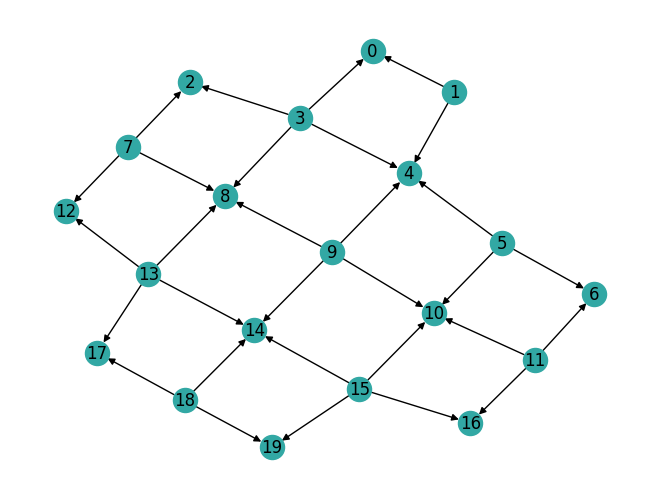

In [27]:
from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout

mpl_draw(backend.coupling_map.graph, arrows=True, with_labels=True, node_color='#32a8a4', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

## 2. Creating a GHZ state

The GHZ (Greenberger-Horne-Zeilinger) state is a maximally entangled quantum state that involves three or more qubits. It is an equal superposition of all qubits being in state 0 and all qubits being in state 1. We will first use 3 qubits of the 54 we have available on the system; this can be represented as:

$$\frac{1}{\sqrt{2}}(∣000⟩+ ∣111⟩)$$

In order to create a GHZ state, we follow the steps below:

<ol>
<li> First, we initiate the process by <b>creating a superposition</b> using a Hadamard gate <span style="    display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">H</span> on a qubit.
</li>
<li>  Then, we <b>apply <span style="display: inline-block; min-width: 1.7rem; text-align: center; background: linear-gradient(0.45turn, rgba(255, 255, 255, 0.1), rgba(0, 0, 0, 0.05)) rgb(80, 90, 98); color: white; padding: 0.1rem; margin: 0.05rem; font-weight: 600; border-radius: 0.2rem;">CNOT</span> gates from one qubit to two other qubits</b>.
</li>
<li> Finally, we perform <b>measurements on all qubits.
</li>
</ol>

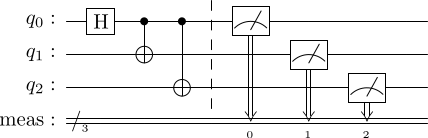

In [2]:
# This syntax will look a little different than you're used to because we need to use Qiskit in order to do custom transpilation later.

from qiskit import QuantumCircuit

num_qb = 3
# Instead of QuantumVariable, we use QuantumCircuit
qc = QuantumCircuit(num_qb)

# Instead of h(qc[0]), we write qc.h(0). Use similar syntax for other gates.
qc.h(0)
for qb in range(1, num_qb):
    qc.cx(0, qb)

qc.measure_all()
qc.draw("latex",  style="clifford")


Executing it is then simply a matter of running the circuit on the backend.

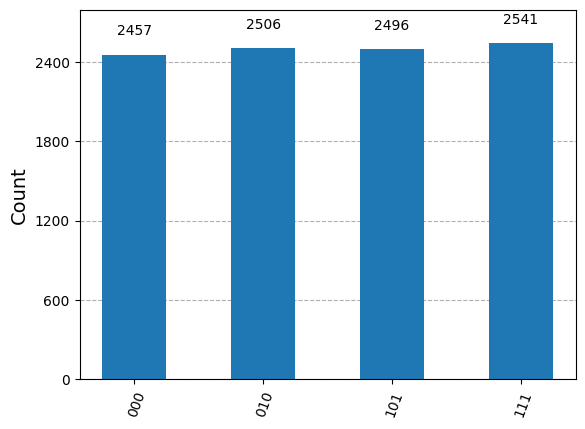

In [3]:
from qiskit.visualization import plot_histogram
from qiskit import transpile

shots = 10000
# again, this looks a little bit different because we're in Qiskit instead of qrisp.
qc_transpiled = transpile(qc, backend=backend)
job = backend.run(qc_transpiled, shots=shots)

res=job.result()
counts=res.get_counts()

plot_histogram(counts)

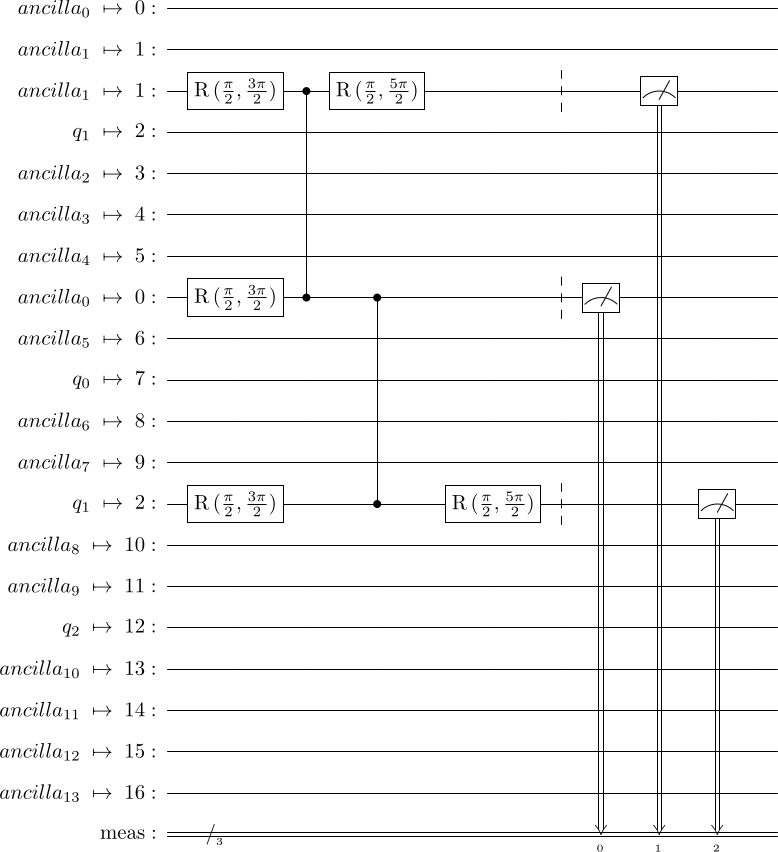

In [4]:
qc_transpiled.draw("latex",style="clifford")

## 3. Creating the GHZ state on a different set of qubits

When running a circuit with fewer qubits than available, we have the possibility to choose the most performant qubits in the QPU.

**Task: Fill in and execute the two code blocks below to create a GHZ state on two different sets of qubits.**

Use the topology of the system to choose a more efficient set of qubits for a GHZ states. Execute them on the real quantum computer and compare the outcomes.

In [5]:
qubits_names_1 = [
    #Labels for the qubits that we're going to use
    "QB1",
    "QB2",
    "QB5",
]

qubits_names_2 = [
#TODO: Pick another set of 3 qubits, ideally the best-performing ones that you can!
    "QB12",
    "QB17",
    "QB16",
]

# Qiskit identifies qubits with integers, so we need to convert those string by using the IQM Backend method
qubits_1 = [backend.qubit_name_to_index(name) for name in qubits_names_1]
qubits_2 = [backend.qubit_name_to_index(name) for name in qubits_names_2]

# Shows the couplings between the qubits we have selected without showing any of the others.
# Importantly, the first qubit on Qiskit is qubit 0, while the first qubit on Resonance is QB1. So QB1 on Resonance corresponds to qubit 0
#   in Qiskit, and QB5 on Resonance corresponds to QB4 on Qiskit.
reduced_coupling_map_1 = [list(edge) for edge in backend.coupling_map if set(edge).issubset(set(qubits_1))]
print("Reduced coupling map: ", reduced_coupling_map_1)
reduced_coupling_map_2 = [list(edge) for edge in backend.coupling_map if set(edge).issubset(set(qubits_2))]
print("Reduced coupling map: ", reduced_coupling_map_2)

Reduced coupling map:  [[1, 0], [1, 4]]
Reduced coupling map:  [[11, 16], [15, 16]]


Keep in mind the reduced coupling maps above to choose on which qubit you should apply the Hadamard and the CNOT gates.

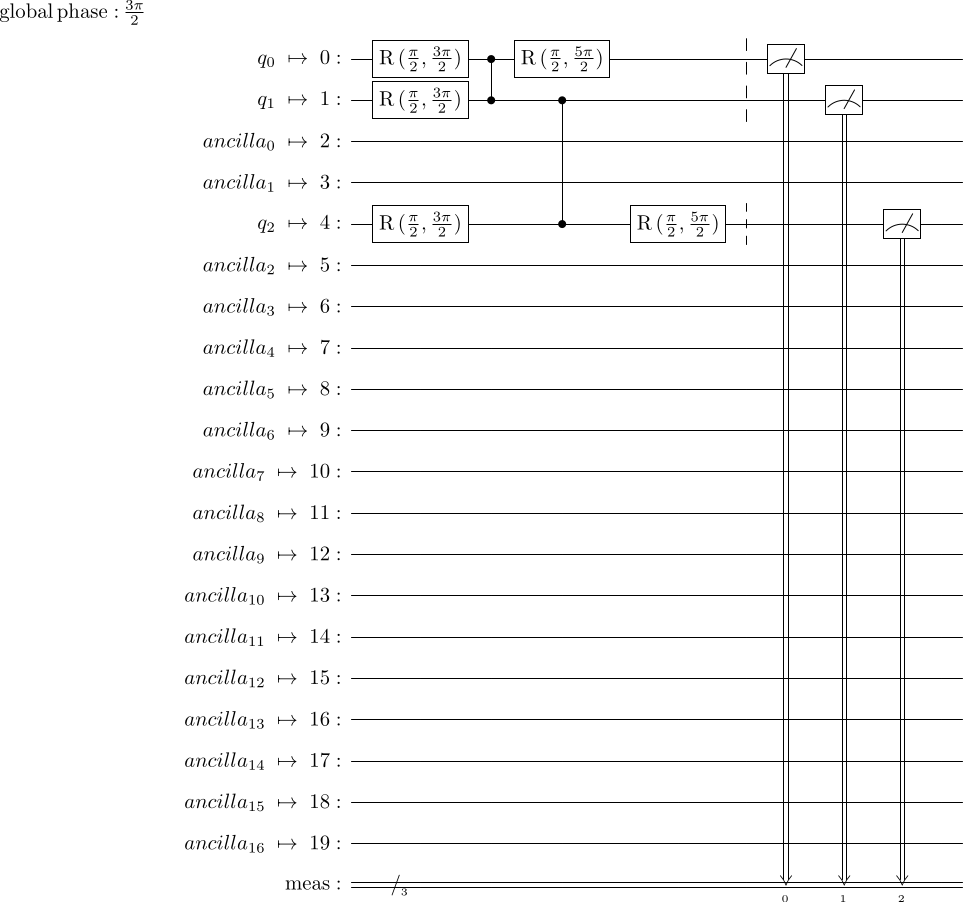

In [6]:
qc1 = QuantumCircuit(num_qb)
# TODO: Add the circuit that acts on qubits_1

qc1.h(1)
qc1.cx(1, 0)
qc1.cx(1, 2)

qc1.measure_all()

qc1_transpiled = transpile(qc1, backend, coupling_map=reduced_coupling_map_1, optimization_level=3)
qc1_transpiled.draw("latex", style="clifford")

Copy and adapt the code cell above to make a GHZ state out of the qubits in the set qubits_2.

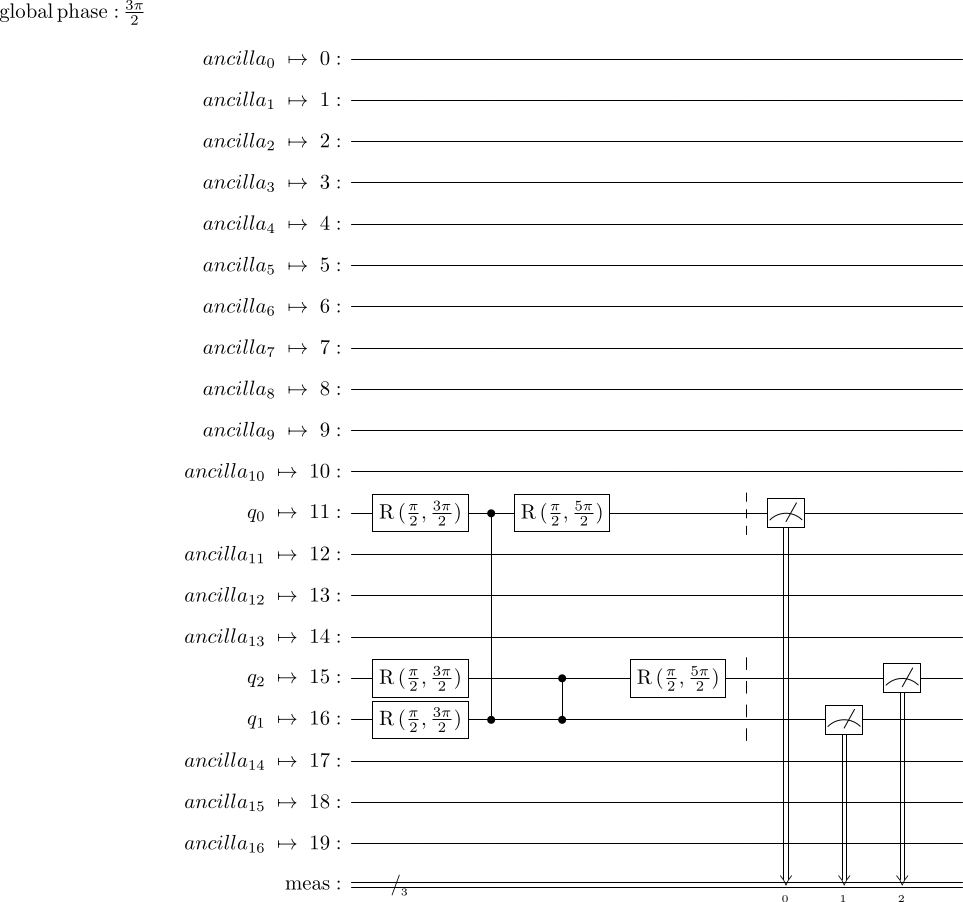

In [7]:
# TODO: Add the circuit that acts on qubits_2

qc2 = QuantumCircuit(num_qb)
# TODO: Add the circuit that acts on qubits_1

qc2.h(1)
qc2.cx(1, 0)
qc2.cx(1, 2)

qc2.measure_all()

qc2_transpiled = transpile(qc2, backend, coupling_map=reduced_coupling_map_2, optimization_level=3)
qc2_transpiled.draw("latex", style="clifford")

Finally, run the next two cells to run both circuits on Resonance and compare the results.

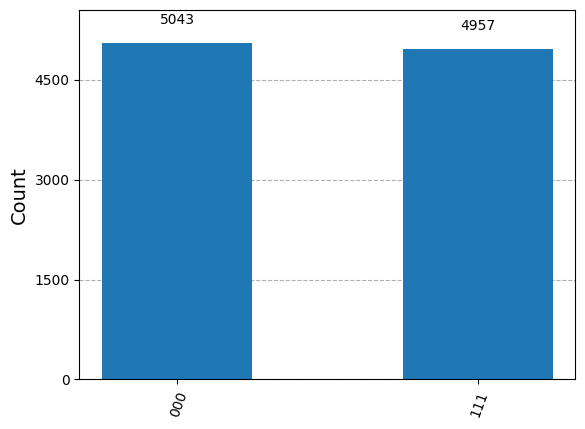

In [8]:
shots = 10000
job1 = backend.run(qc1_transpiled, shots=shots)

res1=job1.result()
counts1=res1.get_counts()

plot_histogram(counts1)

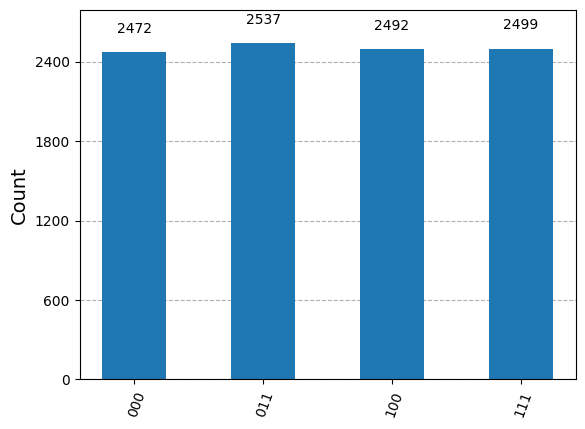

In [9]:
job2 = backend.run(qc2_transpiled, shots=shots)

res2=job2.result()
counts2=res2.get_counts()

plot_histogram(counts2)

## 4. Homework: Making a big GHZ state with good routing

If we try making a GHZ state with more than 5 qubits, we are going to run into routing problems. Why?

If you look at the coupling map, you will notice that no qubit is connected to more than 4 other qubits. If you look back at the circuit we implemented above, it applies CNOT between one qubit and `num_qubits`-1 other qubits. This means that we have a routing problem if `num_qubits > 5`.

An important fact is that if we have a GHZ state of $n$ qubits, we can make a bigger GHZ state with $n+1$ qubits by applying a CNOT gate between *any* qubit in the smaller GHZ state and a new qubit. For example, the following two circuits both create a 3-qubit GHZ state:

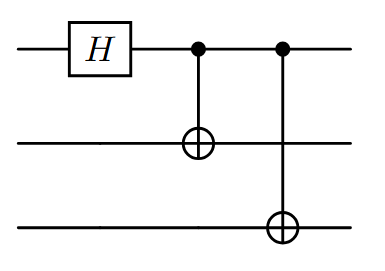

and

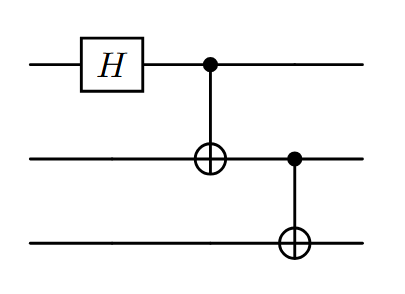

We're going to compare making a big GHZ state the old way and a more efficient way. First, let's write the circuit for the old way:

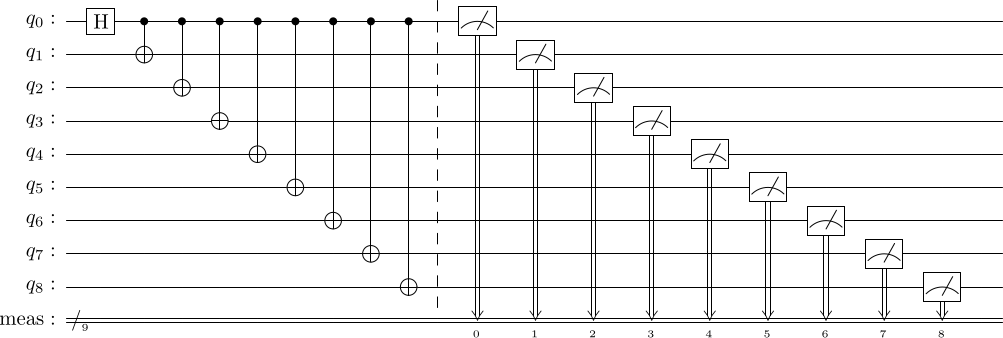

In [11]:
# Make the big GHZ state the old way
num_qb = 9
qc = QuantumCircuit(num_qb)

qc.h(0)
for qb in range(1, num_qb):
    qc.cx(0, qb)

qc.measure_all()
qc.draw("latex",  style="clifford")

In the cell below, create a 9-qubit GHZ state in a well-routed way. Choose the gates and qubits carefully so that all of the gates are between qubits connected by a coupler.

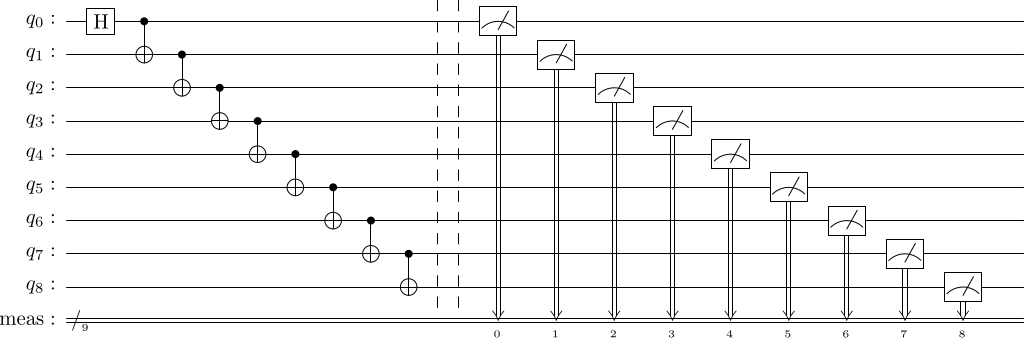

In [15]:
efficient_GHZ_state = QuantumCircuit(9)

# TODO: create a 9-qubit state in a way that works with routing

efficient_GHZ_state.h(0)
efficient_GHZ_state.cx(0, 1)
efficient_GHZ_state.cx(1, 2)
efficient_GHZ_state.cx(2, 3)
efficient_GHZ_state.cx(3, 4)
efficient_GHZ_state.cx(4, 5)
efficient_GHZ_state.cx(5, 6)
efficient_GHZ_state.cx(6, 7)
efficient_GHZ_state.cx(7, 8)

efficient_GHZ_state.barrier()
efficient_GHZ_state.measure_all()

my_nine_qubits = [
    # TODO: add labels for the qubits that we're going to use. The qubit you list first will correspond to big_GHZ_state[0], the second will be
    #   big_GHZ_state[1], and so on.
    "QB3",
    "QB4",
    "QB1",
    "QB2",
    "QB5",
    "QB10",
    "QB11",
    "QB12",
    "QB17"
]

# Draw the circuit. Since we haven't transpiled it yet, it won't use the physical qubits in the drawing, just qubits 0 through 8.
efficient_GHZ_state.draw("latex",  style="clifford")


Now we transpile both circuits on the same 9 qubits that you chose:

Reduced coupling map:  [[1, 0], [1, 4], [3, 0], [3, 2], [3, 4], [9, 4], [9, 10], [11, 10], [11, 16]]


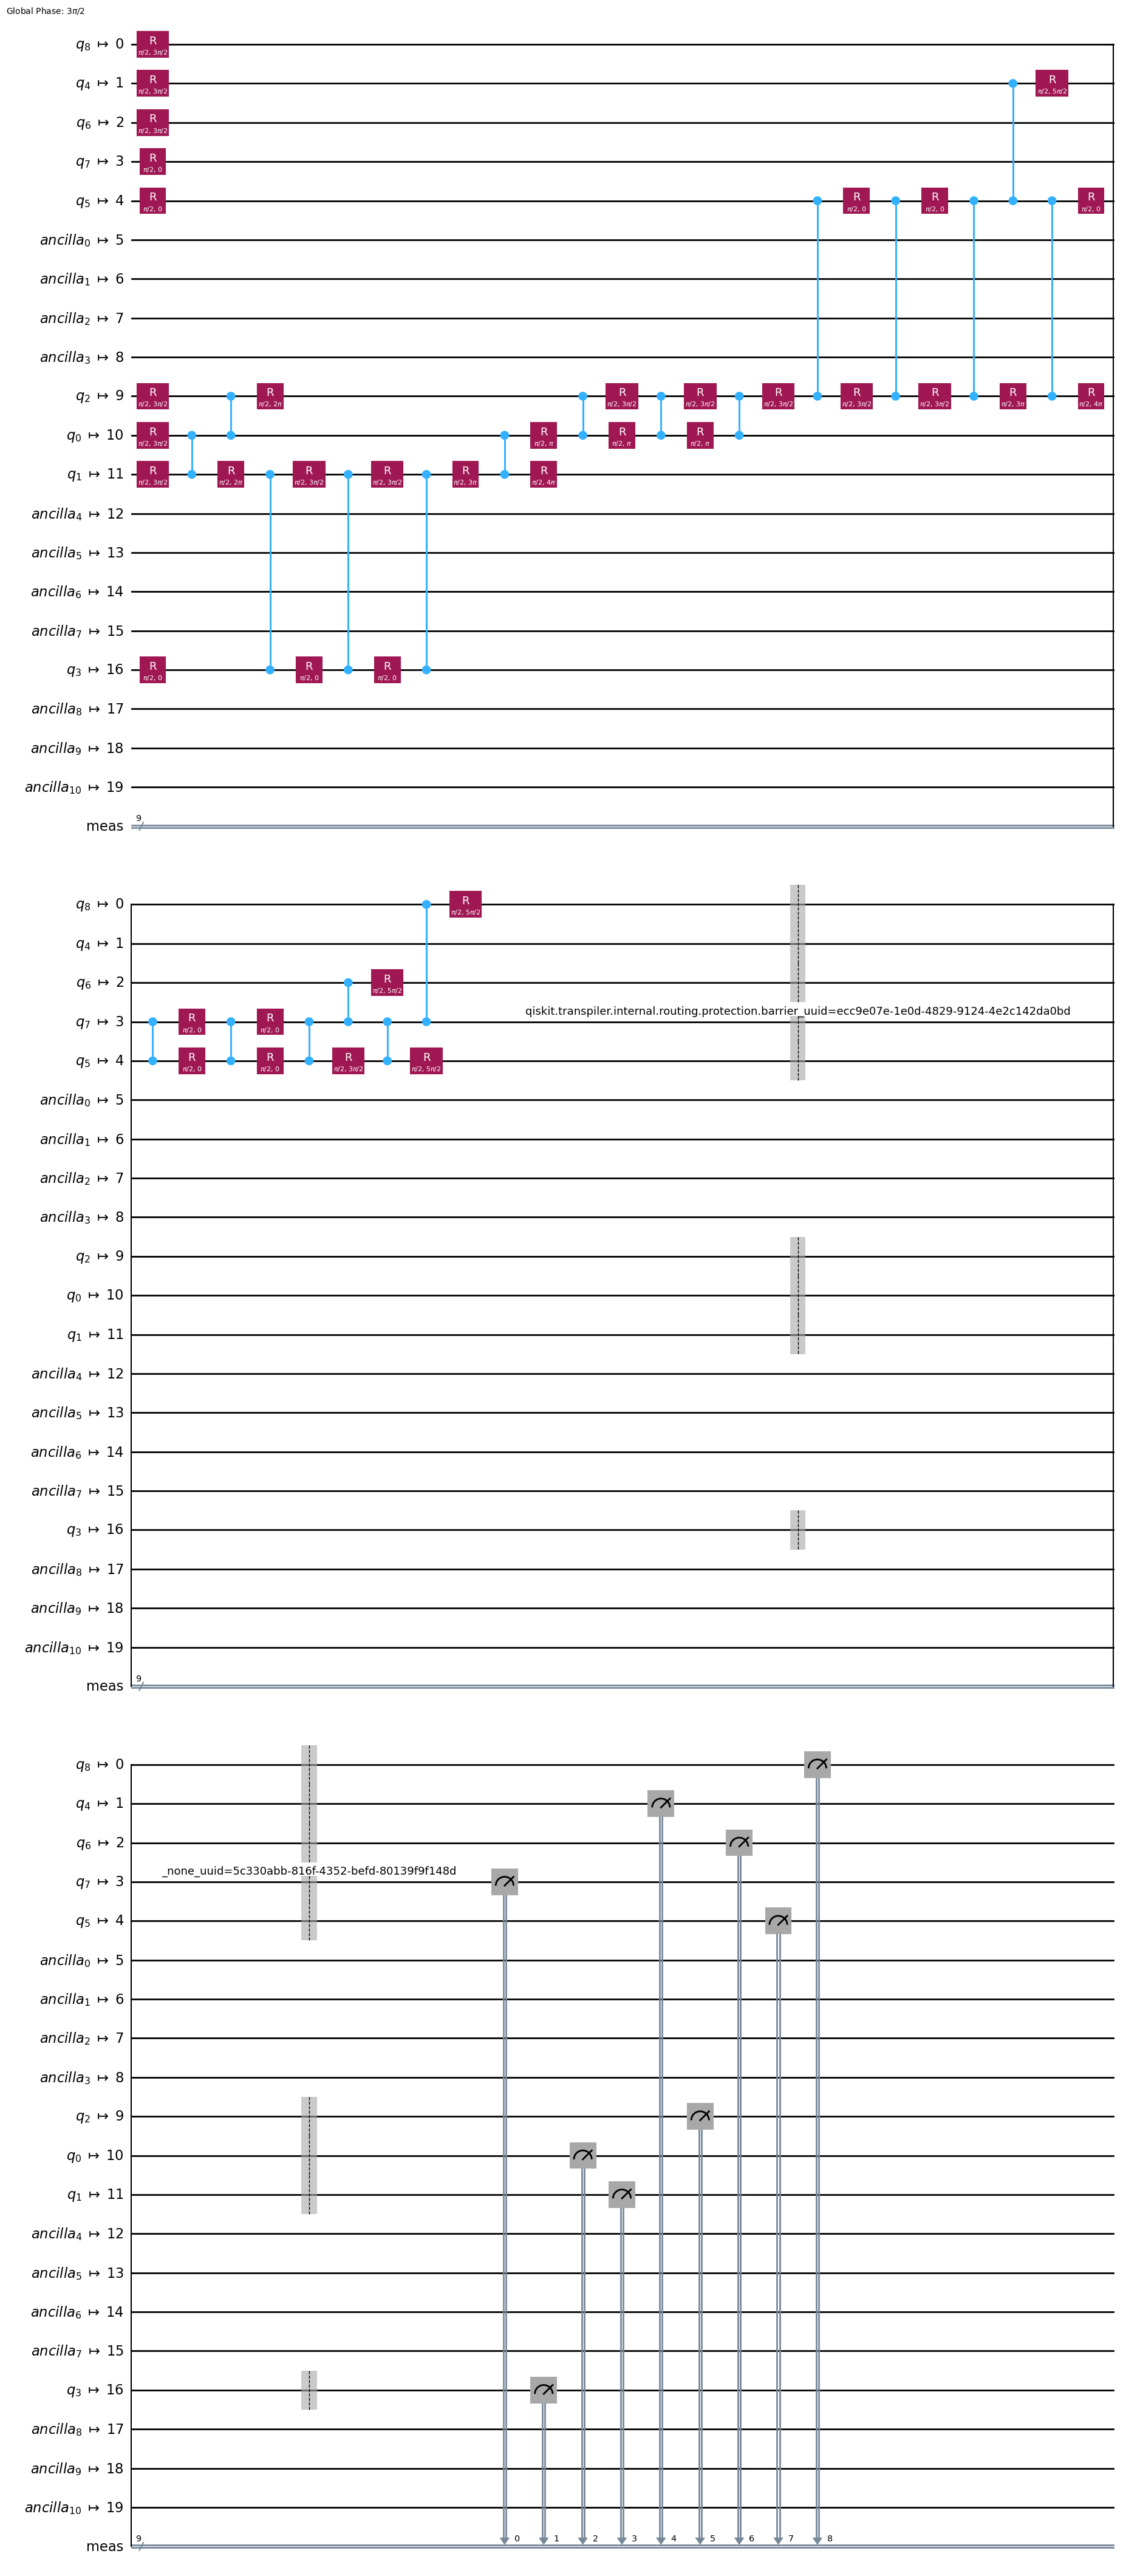

In [20]:
my_qubits = [backend.qubit_name_to_index(name) for name in my_nine_qubits]

#Shows the couplings between the qubits we have selected without showing any of the others.
my_reduced_coupling_map = [list(edge) for edge in backend.coupling_map if set(edge).issubset(set(my_qubits))]
print("Reduced coupling map: ", my_reduced_coupling_map)

qc_transpiled = transpile(qc, backend, coupling_map=my_reduced_coupling_map, optimization_level=1)
efficient_transpiled = transpile(efficient_GHZ_state, backend, coupling_map=my_reduced_coupling_map, optimization_level=1)
qc_transpiled.draw("mpl")

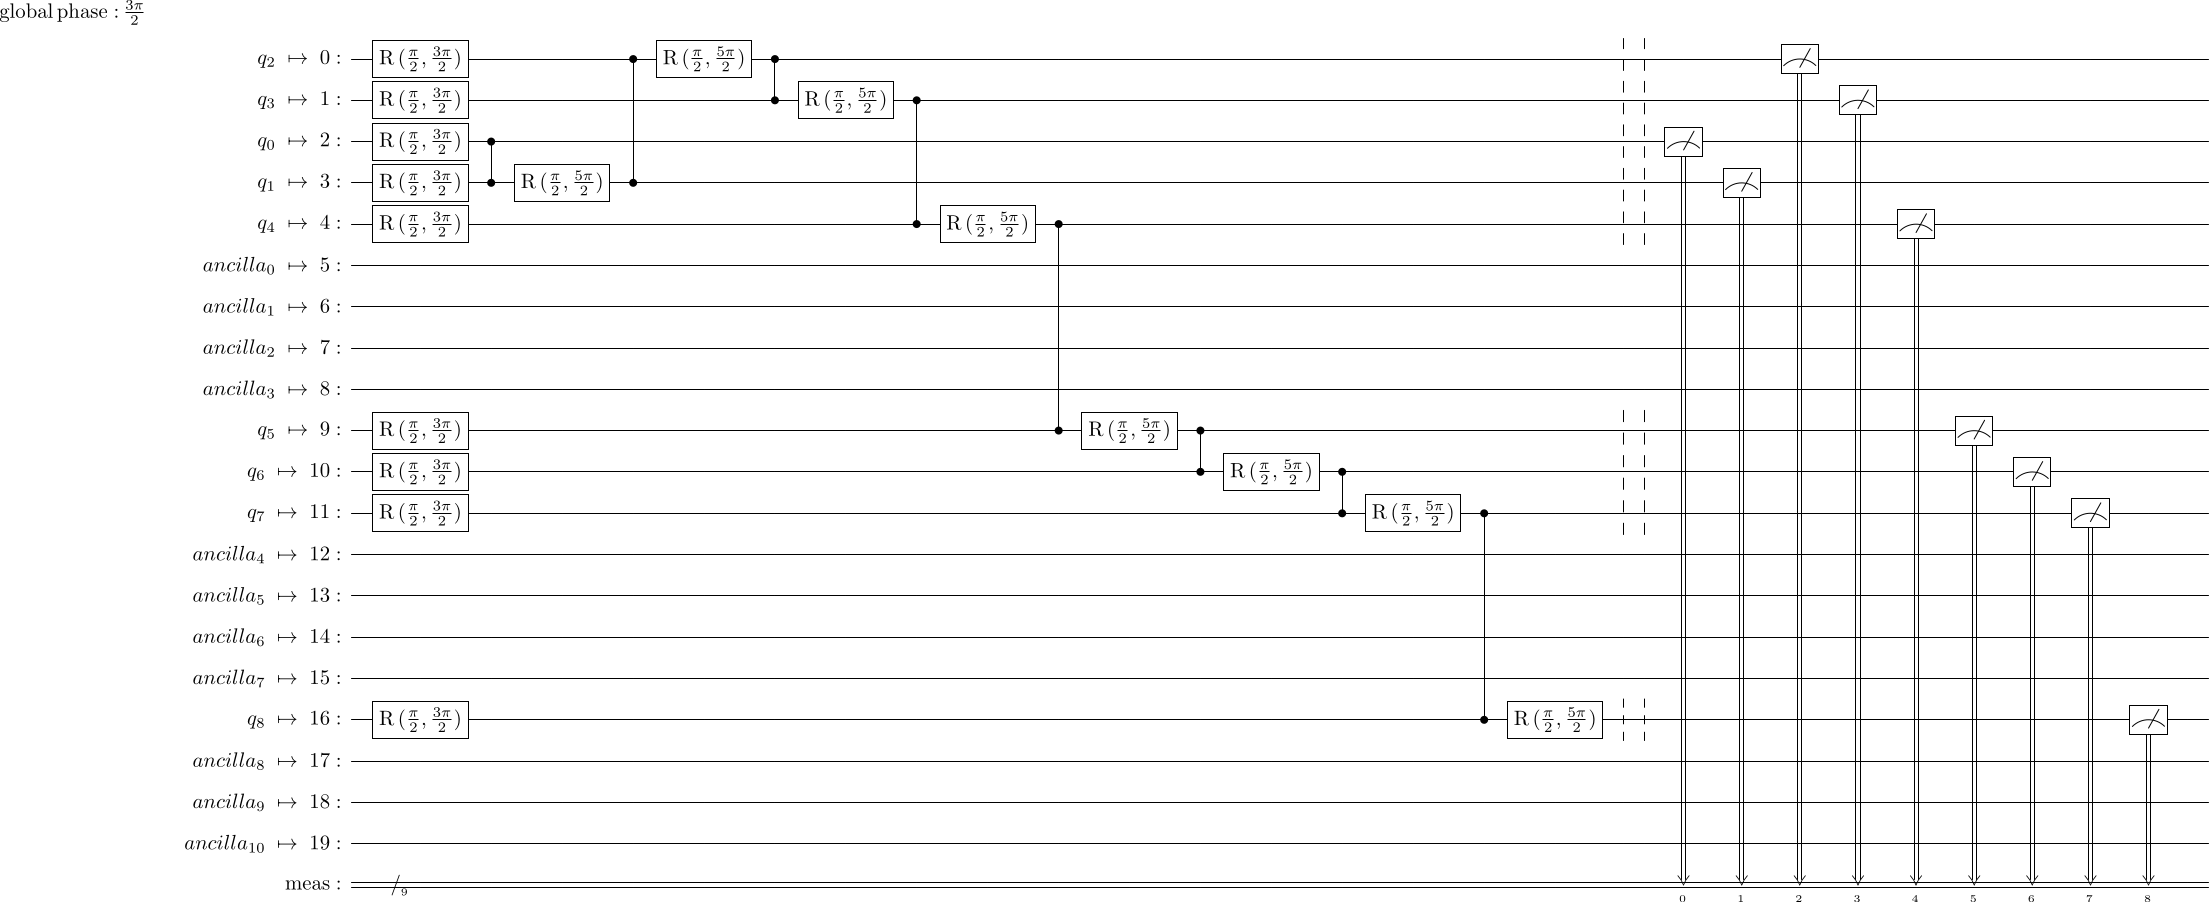

In [17]:
efficient_transpiled.draw("latex", style="clifford")

Finally, run both on the quantum computer and compare the results.

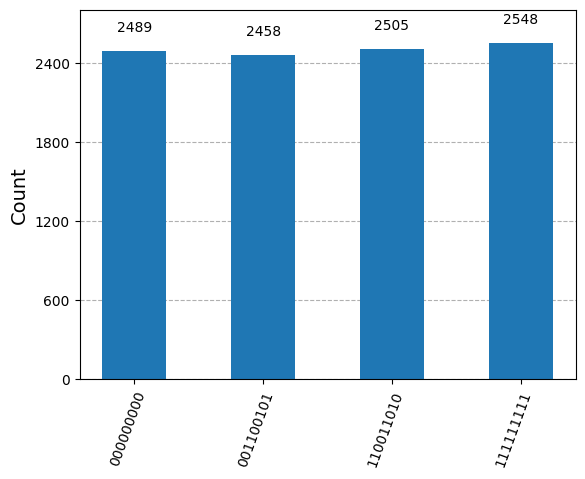

In [21]:
shots = 10000
qc_job = backend.run(qc_transpiled, shots=shots)

qc_res=qc_job.result()
qc_counts=qc_res.get_counts()

plot_histogram(qc_counts)

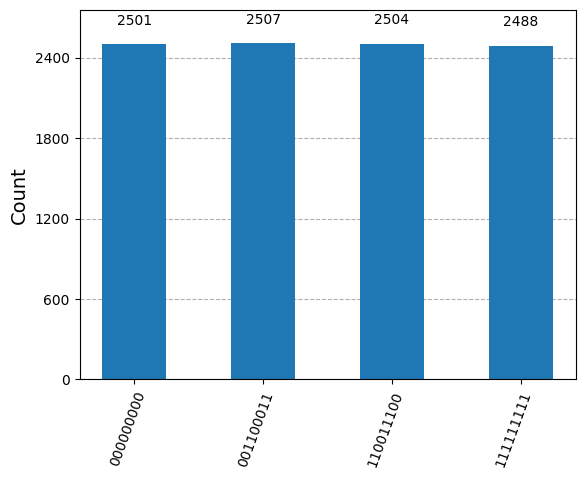

In [22]:
efficient_job = backend.run(efficient_transpiled, shots=shots)

efficient_res=efficient_job.result()
efficient_counts=efficient_res.get_counts()

plot_histogram(efficient_counts)

## 5. For the curious: Verifying genuine multi-qubit entanglement by measuring the GHZ state fidelity

The GHZ state fidelity $F$ is a quantity that acts as a witness for genuine multi-qubit entanglement. That is, it can be mathematically proven that if $F$ is larger than 0.5, then the measurement results cannot be explained without entanglement involving all qubits (more precisely, it has been shown that this is equivalent to measuring a negative expectation value of a multipartite entanglement witness - see [Mooney, 2021](https://iopscience.iop.org/article/10.1088/2399-6528/ac1df7/meta) and references therein). This means that $F$ is a great way to evaluate the "quantumness" of the computer.

The fidelity of a mixed state is computed using the [formula](https://en.wikipedia.org/wiki/Fidelity_of_quantum_states)
$$F(\text{ideal}, \text{measured})= \left(\text{Tr}\sqrt{\sqrt{\rho_{\text{ideal}}}\rho_{\text{measured}}\sqrt{\rho_{\text{ideal}}}}\right)^2$$

where $\rho_{\text{ideal}}$ is the density matrix of an ideal GHZ state (i.e. without noise) and $\rho_{\text{measured}}$ is the density matrix as given by the actual results of the quantum computer. The ideal GHZ state density matrix only has non-zero entries in the four corners of the density matrix $|00...0\rangle\langle00...0|$, $|00...0\rangle \langle11...1|$, $|11...1\rangle \langle00...0|$, $|11...1\rangle \langle11...1|$. This simplifies the process since we only need to measure these four components. In the fidelity formula, all other entries are effectively nullified by the zero entries in the ideal state matrix.

From the experiment above we obtained the diagonal elements of $\rho_{\text{measured}}$, but we still need to measure the coherences along the anti-diagonal. We will use the method of multiple quantum coherences to measure these off-diagonal entries [Mooney, 2021](https://iopscience.iop.org/article/10.1088/2399-6528/ac1df7/meta).

This method leverages the fact that for a GHZ state, a phase rotation $e^{i\phi}$ applied to all $n$ qubits results in the $|11...1\rangle$ component acquiring a cumulative phase of $e^{in\phi}$. The $|00...0\rangle$ component remains unaffected by this phase rotation and does not accumulate any phase. To measure this, we generate a GHZ state, apply phase shifts to all qubits, and then attempt to reverse the state using the circuit that initially created the GHZ state. From this, we can then observe the oscillation of the probability of the $|00...0\rangle$ component as we scan the phase angle from $0$ to $2\pi$. By fourier transforming the signal we can extract the amplitude of the oscillation happening at frequency $n$, which is a measure of the $|00...0\rangle \langle11...1|,|11...1 \rangle \langle00...0|$ coherences.

In order to perform these measurements, we first need to generate the phase-shifter circuits used in the method of multiple quantum coherences. We will create $2n+2$ of these circuits, which is the maximal step-size for detecting a signal oscillating at frequency $n$ according to the [Nyquist–Shannon sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem).

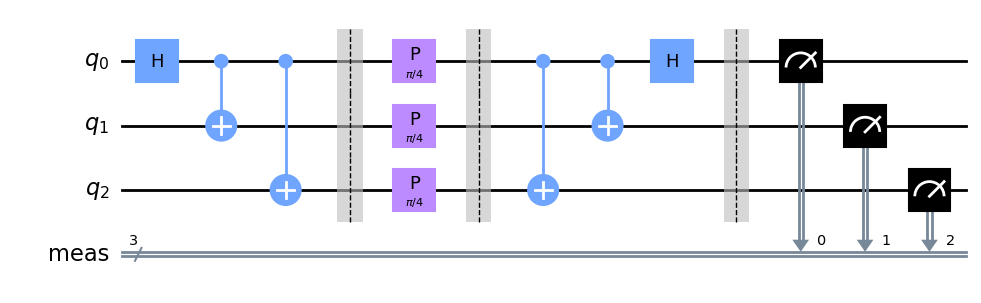

In [35]:
import numpy as np

phases=[np.pi*i/(num_qb +1) for i in range(2*num_qb+2)] # Creating phase shifts at intervals 1/(2n+2)

circuits=[]
for phase in phases:
    qc = QuantumCircuit(num_qb)

    # Creating a GHZ state
    qc.h(0)
    for qb in range(1, num_qb):
        qc.cx(0, qb)


    qc.barrier()
    #adding phases
    for i in range(num_qb):
        qc.p(phase,i)
    qc.barrier()

    # Undoing GHZ can be acchieved by applying the same operations as above in reverse order
    for qb in range(1, num_qb):
        qc.cx(0, num_qb - qb)
    qc.h(0)

    #measure
    qc.measure_all()
    circuits.append(qc)

# Draw a circuit as an example
circuits[1].draw('mpl', style="clifford")

Now we are ready to send our circuits to the quantum computer. Instead of sending them individually, we can send them all at once in a single batch for faster execution. A batch is a list that contains several circuits and, under most circumstances, is more time-efficient.

In [42]:
circuits_transpiled = transpile(circuits, backend, optimization_level=3)
job = backend.run(circuits_transpiled, shots=10000)#shots)
all_counts = job.result().get_counts()

CircuitExecutionError: Not enough credits to execute job

With our job completed, we can collect the results from the system and use them to calculate the coherences and the fidelity of the GHZ state.

In [37]:
all_zero_probability_list=[] # An ordered list for storing the probabilites of returning to the |000> state

for count in all_counts:
    probability = count['0'*num_qb]/shots
    all_zero_probability_list.append(probability)

# Computing the phase acquired by the |111> component for each interval
complex_coefficients = np.exp(1j*num_qb*np.array(phases))

# Extracting coherence parameter i_n using the Fourier transform
i_n = np.abs(np.dot(complex_coefficients,np.array(all_zero_probability_list)))/(len(phases))

# Extracting the probabilites of the 000 and 111 bitstrings
# from the results of point 2 of this notebook
counts_direct = res.get_counts()
probs_direct = {label: count / shots for label, count in counts_direct.items()}

# Computing GHZ state fidelity from i_n and the probabilites according to the method in [Mooney, 2021]
fidelity=(probs_direct['0'*num_qb]+probs_direct['1'*num_qb] + 2 * np.sqrt(i_n))/2

print("Measured GHZ Fidelity = " + str(fidelity))

NameError: name 'all_counts' is not defined

Is the result higher or lower than $0.5$?
A fidelity of $0.5$ would be sufficient for certifying the "quantumness" of the device through genuine multi-qubit entanglement: The measurement results cannot be explained through fewer then 3 qubits entangled.

**Task: Adapt the code cells above and create a GHZ state with more qubits and measure its fidelity. If the result is higher than $0.5$, keep going - make the biggest GHZ state that can is certifiably "quantum."**

In [ ]:
# Copyright 2024 IQM Quantum Computers (Hermanni Heimonen, Stefan Seegerer, Stefan Pogorzalek, Nadia Milazzo)
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.